In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
sns.set()
import os
import pandas as pd

In [2]:
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0,145,160],
    [0, 170, 230],
    [250,180,35],
    [0,70,125],
    [175, 25, 60],
    [170, 200 ,70],
    [250,115,80],
    [140, 90, 180],
      
])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

In [3]:
files = "/gpfs/work/machnitz/plankton_dataset/new_data/4David/M160/Sorted"

folders = glob.glob(os.path.join(files, "*"))

In [4]:
data_distribution = {}
for folder in folders:
    if os.path.isfile(folder):
        continue
    data_distribution[os.path.split(folder)[-1]] = [sum([len(files) for r, d, files in os.walk(folder)])]

dist_df = pd.DataFrame.from_dict(data_distribution).T.reset_index().rename(columns={"index":"species", 0:"count"}).sort_values(by="species")

In [5]:
dist_df

,species,count
9,Appendicularia,85
16,Blurry,178999
17,Bubbles,6309
12,Ceratocoris,80
18,Copepods,2416
3,Dinoflagellates,143
7,Foraminifera,226
2,Gastropoda,127
0,Jellyfish,111
11,MarineSnow_Comet,552


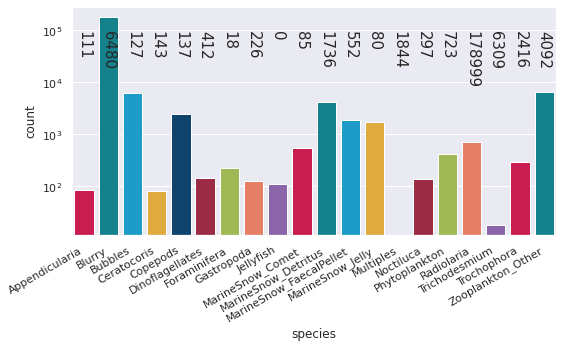

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.barplot(x="species", y="count", data=dist_df, ax=ax, palette=hereon_color_array)
ax.set_yscale("log")
plt.gca()
fig.autofmt_xdate()

for i, (key,value) in enumerate(data_distribution.items()):
    ax.text(i, 100000, f"{value[0]}".strip(), verticalalignment="top", horizontalalignment="center", rotation=-90, fontsize=15)
plt.tight_layout()
plt.savefig("Data_distribution_log.png", dpi=600)
plt.show()

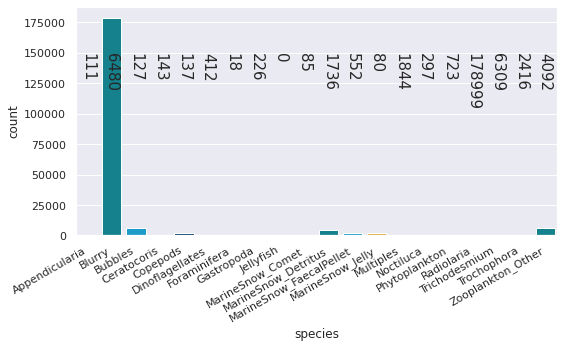

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.barplot(x="species", y="count", data=dist_df, ax=ax, palette=hereon_color_array)
plt.gca()
fig.autofmt_xdate()

for i, (key,value) in enumerate(data_distribution.items()):
    ax.text(i, 150000, f"{value[0]}".strip(), verticalalignment="top", horizontalalignment="center", rotation=-90, fontsize=15)
plt.tight_layout()
plt.savefig("Data_distribution_linear.png", dpi=600)
plt.show()

In [8]:
# labeled vs unlabeled data:

# get unlabeled images:
unlabeled_files = ["/gpfs/work/machnitz/plankton_dataset/new_data/4Tobi/", "/gpfs/work/machnitz/plankton_dataset/cpics/"]

len_files = 0
for folder in unlabeled_files:
    len_files += sum([len(files) for r, d, files in os.walk(folder)])

In [9]:
file_comp = {
    "labeled": [dist_df["count"].sum()],
    "unlabeled": [len_files]
}

vs_df = pd.DataFrame.from_dict(file_comp).T.reset_index().rename(columns={"index":"kind", 0:"count"})
vs_df

,kind,count
0,labeled,204787
1,unlabeled,232733


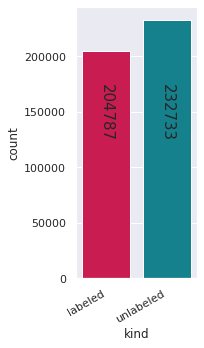

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,5))
sns.barplot(x="kind", y="count", data=vs_df, ax=ax, palette=hereon_color_array)
# ax.set_yscale("log")
plt.gca()
fig.autofmt_xdate()

for i, (key,value) in enumerate(file_comp.items()):
    ax.text(i, 175000, f"{value[0]}", verticalalignment="top", horizontalalignment="center", rotation=-90, fontsize=15)

# ax.set_ylim(2400000)
plt.tight_layout()
plt.savefig("labeled_vs_unlabeled.png", dpi=600)
plt.show()

In [11]:
value

[232733]

In [12]:
probabilities = np.array([0.3, 0.5, 0.1, 0.1])
p_balanced_per_class = 0.25
p_corrected_per_class = np.array([0.97, 0.01, 0.01, 0.01])

corrected_enumerator = (p_corrected_per_class / p_balanced_per_class) * probabilities
corrected_denominator = corrected_enumerator + (
    ((1 - p_corrected_per_class) / (1 - p_balanced_per_class)) * (1 - probabilities)
)
result = corrected_enumerator / corrected_denominator
result.sum()

1.0126332412159496

In [13]:
df = vs_df.copy()[::-1]
df.loc[0, "count"] = 0.79
df.loc[1, "count"] = 0.83
df.loc[0, "kind"] = "Supervised"
df.loc[1, "kind"] = "SimCLR"

df = df.rename(columns={"kind": "Model", "count":"Accuracy"})

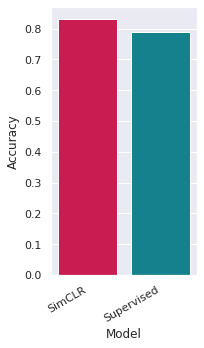

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,5))
sns.barplot(x="Model", y="Accuracy", data=df, ax=ax, palette=hereon_color_array)
# ax.set_yscale("log")
plt.gca()
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig("simclr_vs_supervised_top1_acc.png", dpi=600)
plt.show()

# Get Data fromd dataloader

In [15]:
import os
import pickle
import sys
from datetime import datetime as dt

import hydra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torchmetrics
import copy
from tqdm.auto import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

sys.path.append("..")

from src.lib.config import register_configs  # noqa
from src.utils.EvalWrapper import EvalWrapper  # noqa
from src.utils import utils  # noqa
from src.utils.eval_single_helper_funcs import get_confidence_and_acc_single, get_distribution_file  # noqa
from src.models.LightningBaseModel import LightningModel  # noqa
from src.utils.eval_single_helper_funcs import get_best_checkpoints  # noqa

register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)

sns.set()

In [16]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_singlelabel",
                                                     "random_seed=7",
                                                     "strategy=SingleDevice",
                                                     'strategy.device="cuda:0"',
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=64"])

train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="fit")

Global seed set to 7
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
77it [00:00, 6955.28it/s]                                                                                                   | 0/19 [00:00<?, ?it/s]
4536it [00:00, 13521.14it/s]
88it [00:00, 14335.60it/s]█████                                                                                     | 2/19 [00:00<00:02,  5.67it/s]
100it [00:00, 15093.40it/s]
95it [00:00, 14818.66it/s]
288it [00:00, 15963.94it/s]
12it [00:00, 9694.08it/s]
158it [00:00, 15311.57it/s]
59it [00:00, 13978.64it/s]
1215it [00:00, 23987.42it/s]
386it [00:00, 27736.40it/s]███████████████████████████████████████████▍                                            | 10/19 [00:00<00:00, 25.19it/s]
56it [00:00, 14199.93it/s]
1290it [00:00, 26614.00it/s

In [17]:
train_dataloader = datamodule.train_dataloader()

In [18]:
_, names = zip(*datamodule.train_data.files)

In [19]:
names, counts = np.unique(np.array(names), return_counts=True)
df = pd.DataFrame.from_dict({
    "Species": names,
    "Count": list(copy.copy(counts))
})

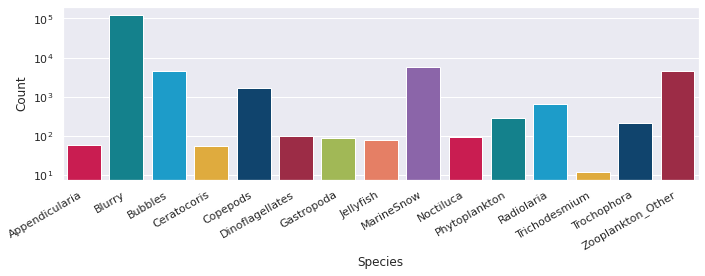

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
sns.barplot(x="Species", y="Count", data=df, ax=ax, palette=hereon_color_array)
ax.set_yscale("log")
plt.gca()
fig.autofmt_xdate()

# for i, (key,value) in enumerate(data_distribution.items()):
#     ax.text(i, 100000, f"{value[0]}".strip(), verticalalignment="top", horizontalalignment="center", rotation=-90, fontsize=15)
plt.tight_layout()
plt.savefig("Data_distribution_log.pdf")
plt.show()

In [21]:
list(counts)

[59, 125299, 4416, 56, 1691, 100, 88, 77, 5755, 95, 288, 664, 12, 207, 4536]